In [1]:
import matplotlib.pyplot as plt # for plotting maps
import maup # mggg's library for proration, see documentation here: https://github.com/mggg/maup
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
from statistics import mean, median
from functools import reduce
import matplotlib.pyplot as plt
from textwrap import wrap
from collections import defaultdict
from tqdm.notebook import tqdm
import os
import pickle as pkl

from IPython.display import clear_output

%matplotlib inline

pd.set_option("display.max_rows", 150)
pd.set_option("display.max_columns", 150)
plt.rcParams.update({'figure.max_open_warning': 0})

DATA_PATH = "raw-from-source/"
CRS = 3857

/Users/SamSpinner/anaconda3/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


#### VEST documentation:

----

From VEST: 

* Election results from the Colorado Secretary of State (https://www.sos.state.co.us/pubs/elections/Results/Archives.html)
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program Phase 2 release. The following counties used shapefiles sourced from the respective county governments instead: Adams, Arapahoe, Boulder, Chaffee, Delta, Denver, Douglas, El Paso, Fremont, Garfield, Gilpin, Jefferson, La Plata, Larimer, Mesa, Pitkin, Pueblo, Summit, Weld.  

* Las Animas County precinct assignments in the voter file differ markedly from both the Census VTD boundaries and from maps received from the county. All precincts were revised to match the geocoded voter file and the list of districts assigned to precinct splits. As appropriate, precinct boundaries were revised using Census blocks, the Trinidad municipal boundary shapefile, school district or fire district boundaries, and the parcel shapefile from the Las Animas County Assessor. 

* The following additional revisions were made to match the 2016 precinct boundaries: 

     1. Lake: Revise Precincts 1/4, 2/3 to reverse 2017 redraw
     2. Logan: Align Sterling City precincts with city limits
     3. Montezuma: Precincts renumbered to match county maps
     4. Otero: Align La Junta City precincts with county maps
     5. Prowers: All precincts adjusted to match county maps
     6. Rio Grande: Adjust Precincts 2/3 to match county maps
     

* Larimer County reported provisional votes countywide. These were distributed to precincts by candidate based on their share of the vote reported by precinct. *

G16PREDCLI - Hillary Clinton (Democratic Party) \
G16PRERTRU - Donald J. Trump (Republican Party) \
G16PRELJOH - Gary Johnson (Libertarian Party) \
G16PREGSTE - Jill Stein (Green Party) \
G16PREUMCM - Evan McMullin (Unaffiliated) \
G16PREOOTH - Other Candidates 

G16USSDBEN - Michael Bennet (Democratic Party) \
G16USSRGLE - Darryl Glenn (Republican Party) \
G16USSLTAN - Lily Tang Williams (Libertarian Party) \
G16USSGMEN - Arn Menconi (Green Party) \
G16USSOOTH - Other Candidates 

G16RGTDMAD - Alice Madden (Democratic Party) \
G16RGTRGAN - Heidi Ganahl (Republican Party)

#### VEST Data:

----

**co_2016.shp** 

Found at this [link](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/NH5S2I). 

#### Election Data:

----

**2016GeneralResultsPrecinctLevel.xlsx** 

Found at this [link](https://www.sos.state.co.us/pubs/elections/Results/archive2000.html).

### Part 1: Election Results

In [2]:
master_vest_df = gp.read_file("raw-from-source/vest/co_2016.shp")
master_sos_df = pd.read_excel("raw-from-source/sos/2016GeneralResultsPrecinctLevel.xlsx")

In [3]:
vest_df = master_vest_df.copy()
vest_df = vest_df.to_crs(CRS)

print(len(vest_df))

3010


#### Convert names from the raw data files to their VEST equivalents:

In [4]:
vest2raw_conversion = { 
    "G16PREDCLI" : "Hillary Clinton / Tim Kaine", 
    "G16PRERTRU" : "Donald J. Trump / Michael R. Pence", 
    "G16PRELJOH" : "Gary Johnson / Bill Weld", 
    "G16PREGSTE" : "Jill Stein / Ajamu Baraka", 
    "G16PREUMCM" : "Evan McMullin / Nathan Johnson", 
    "G16PREOOTH" : "President/Vice President", 
    "G16USSDBEN" : "Michael Bennet", 
    "G16USSRGLE" : "Darryl Glenn", 
    "G16USSLTAN" : "Lily Tang Williams", 
    "G16USSGMEN" : "Arn Menconi", 
    "G16USSOOTH" : "United States Senator", 
    "G16RGTDMAD" : "Alice Madden", 
    "G16RGTRGAN" : "Heidi Ganahl" 
} 

raw2vest = {val : key for key, val in vest2raw_conversion.items()}

#### Rename all candidates included in VEST, combine all candidates that VEST does not explicitly separate:

In [5]:
sos_df = master_sos_df.copy()

prc2county = {str(prc) : county for prc, county in zip(sos_df["Precinct"], sos_df["County"])}
offices = ["President/Vice President", "United States Senator", "Regent Of The University Of Colorado - At Large"]
sos_df = sos_df[sos_df["Office/Issue/Judgeship"].isin(offices)].copy()
temp = pd.pivot_table(sos_df, index="Precinct", columns=["Office/Issue/Judgeship", "Candidate"], values="Candidate Votes", aggfunc="first")

convert = lambda name: raw2vest[name] if name in raw2vest else name

office2names = {}

for office in offices:
    office2names[office] = set(temp[office].keys().to_list())
    
name2office = {val : key for key, lst in office2names.items() for val in lst}

temp = pd.pivot_table(sos_df, index="Precinct", columns=["Candidate"], values="Candidate Votes", aggfunc="first")

temp.rename(columns={old: raw2vest[old] for old in raw2vest}, inplace=True)

for office in offices[:-1]:
    names = office2names[office]
    names = set(names) - set(raw2vest.keys())
    temp[raw2vest[office]] = temp[names].sum(axis=1)
    temp.drop(columns=names, inplace=True)

In [6]:
sos_df = temp.copy()

sos_df.reset_index(inplace=True)
sos_df["Precinct"] = sos_df["Precinct"].astype('str')
sos_df["County"] =  sos_df["Precinct"].apply(lambda prc: prc2county[prc])

sos_df.sort_values(by="Precinct", inplace=True)

#### Confirm that "Precinct" column will serve as basis for merge:

In [7]:
in_sos = sos_df[~sos_df["Precinct"].isin(vest_df["PRECINCT"])]
in_vest = vest_df[~vest_df["PRECINCT"].isin(sos_df["Precinct"])]
print(len(in_sos))
print(len(in_vest))

in_sos

1
0


Candidate,Precinct,G16RGTDMAD,G16USSGMEN,G16USSRGLE,G16PRERTRU,G16PREUMCM,G16PRELJOH,G16RGTRGAN,G16PREDCLI,G16PREGSTE,G16USSLTAN,G16USSDBEN,G16PREOOTH,G16USSOOTH,County
3010,Provisional,14.0,NaN,11.0,12.0,NaN,4.0,14.0,15.0,1.0,3.0,15.0,0.0,0.0,Larimer


#### Need to distribute Larimer counties' provisional votes:

Because there are less votes than total precincts, one vote for candidate is assigned to a rank ordering of the precincts that already tallied the most votes for that candidate. 

For example, if 3 provisional votes were counted for Candidate A, then 1 vote would be assigned to the precinct that already had the most votes for Candidate A, 1 vote would be assigned to the precinct that had the second most votes for Candidate A, and 1 vote would be assigned to the precinct with the third most votes for Candidate A.  

In [8]:
larimer = sos_df[sos_df["County"].isin(["Larimer"])].copy()

for idx, col in enumerate(in_sos.keys()):
    if "G16" not in col:
        continue
    prov_votes = in_sos[col].iloc[0]
    
    if np.isnan(prov_votes):
        continue
        
    prov_votes = int(prov_votes)
    if prov_votes == 0:
        continue
        
    idxs_to_add = np.argsort(larimer[col].to_numpy())[::-1][:prov_votes]
    
    larimer.iloc[idxs_to_add, idx] += 1
    

#### Filter out old Larimer data and add in the Larimer data with distributed provisional vote counts. 

In [9]:
sos_df = sos_df[sos_df["County"] != "Larimer"]
sos_df = pd.concat([sos_df, larimer], axis=0)

In [10]:
sos_df.rename(columns={"Precinct" : "PRECINCT"}, inplace=True)
election_df = vest_df.merge(sos_df, on="PRECINCT", how="left")

In [11]:
def validater_row_vect(df, name_column, column_list, verbose=False):
    
    # unique IDs for each precinct
    county_join_cols = (df[name_column]).to_numpy()
    
    wrong_idxs = np.zeros(len(df))
    
    for i in column_list:
        left_data = df[i + "_x"].to_numpy()
        right_data = df[i + "_y"].to_numpy()
        
        local_idxs = np.where(left_data != right_data)
        wrong_idxs[local_idxs] = 1
        
    different_rows = np.sum(wrong_idxs)
    matching_rows = len(df) - different_rows
    
    diff_list = county_join_cols[np.where(wrong_idxs == 1)]
    diff_counties = list(set([county[:2] for county in diff_list]))
    
    if int(different_rows) != 0 or verbose:
        print("There are ", len(df.index)," total rows")
        print(f"{int(different_rows)} of these rows have election result differences")
        print(f"{int(matching_rows)} of these rows are the same")
        print(diff_list)
        print("")
        
    return (int(different_rows) == 0, diff_list)

cols = [col for col in vest_df.keys() if "G16" in col]
result, wrong_prcs = validater_row_vect(election_df, "PRECINCT", cols)

print("Are the election results equal?")
print(result)

Are the election results equal?
True


### Part 2: Shapefiles

Because shapefiles were sourced from both local county data and the U.S. Census, validating the shapefile geometries is also split into 2 sections. We first examine counties whose shapefiles came from the Census, and then the counties whose shapefiles were acquired by reaching out to county officials directly. 

In [12]:
def get_county_shapefile(paths, county):
    """
    Quick way to load a shapefile for a specific county. 
    """
    
    if county in county2shape_cache:
        return county2shape_cache[county]
    
    c = county.strip().replace(" ","_").lower()
    paths = [p for p in paths if c == p.split('/')[-1]]
    
    if len(paths) == 0:
        return None
    
    path = paths[0]
    file = [f for f in os.listdir(path) if f.endswith('shp')]
    
    
        
    file = file[0]
    df = gp.read_file(path + "/" + file)
    df = df.to_crs(CRS)
    
    county2shape_cache[county] = df.copy()
    
    return df

#### We first examine counties whose shapefiles were taken from the Census Redistricting Data Program Phase 2 release. 

In [13]:
county2shape_cache = {}

In [57]:
fp2county = {l.split(',')[1].strip() : l.split(',')[0].strip() for l in open("raw-from-source/county2fps.txt", "r").readlines()}
vest_df["COUNTY"] = vest_df["COUNTYFP"].apply(lambda fp: fp2county[fp])

counties = vest_df["COUNTY"].unique()

# only consider paths to county data taken from census phase 2 release
relevant_paths = ["raw-from-source/census_p2/" + \
                  f for f in os.listdir("raw-from-source/census_p2/")]

census_shape_dfs = [(get_county_shapefile(relevant_paths, county), county) for county in counties]

census_shape_dfs = [df for df in census_shape_dfs if df[0] is not None]
census_shape_dfs = [(df[0].to_crs(CRS), df[1]) for df in census_shape_dfs]

add_county = []

# label each dataframe with its county
for df, county in census_shape_dfs:
    df["County"] = county
    add_county.append((df, county))
    
census_shape_dfs = add_county


#### Combine the census-counties into one dataframe, filter those counties out of VEST's dataframe for comparison. 

In [58]:
census_counties = [df[1] for df in census_shape_dfs]

election_census_df = election_df[election_df["County"].isin(census_counties)].copy()

election_census_df.reset_index(inplace=True)
election_census_df.rename(columns={"index" : "orig_index"}, inplace=True)

census_raw_shapes = gp.GeoDataFrame(pd.concat([val[0] for val in census_shape_dfs], axis=0))

census_raw_shapes.reset_index(inplace=True)
census_raw_shapes.rename(columns={"index" : "orig_index"}, inplace=True)

census_raw_shapes.crs = CRS
election_census_df.crs = CRS

print("Dimensions of each dataframe:")
print("VEST for census_p2 counties:", election_census_df.shape)
print("Concatenated census_p2 counties:", census_raw_shapes.shape)
print()

print("One duplicated VTDST for VEST and the census.")
print(len(election_census_df["VTDST"]), len(election_census_df["VTDST"].unique()))
print(len(census_raw_shapes["VTDST"]), len(census_raw_shapes["VTDST"].unique()))


Dimensions of each dataframe:
VEST for census_p2 counties: (485, 34)
Concatenated census_p2 counties: (484, 18)

One duplicated VTDST for VEST and the census.
485 484
484 483


#### The duplicate VTD is 027001, present in both Hinsdale and Custer county. Rename below:

In [59]:
election_census_df.iloc[105, 3] = "027001-Custer"
census_raw_shapes.iloc[105, 3] = "027001-Custer"

#### There is 1 additional VTDST in Las Animas county in the VEST file when compared to raw census data, but this is not surprising, as VEST documents that they made significant alterations to Las Animas County precinct shapes.

In [60]:
in_e = election_census_df[~election_census_df["VTDST"].isin(census_raw_shapes["VTDST"])]
in_raw = census_raw_shapes[~census_raw_shapes["VTDST"].isin(election_census_df["VTDST"])]
print(len(in_e))
print(len(in_raw))
in_e

1
0


,orig_index,STATEFP,COUNTYFP,VTDST,NAME,PRECINCT,G16PREDCLI_x,G16PRERTRU_x,G16PRELJOH_x,G16PREGSTE_x,G16PREUMCM_x,G16PREOOTH_x,G16USSDBEN_x,G16USSRGLE_x,G16USSLTAN_x,G16USSGMEN_x,G16USSOOTH_x,G16RGTDMAD_x,G16RGTRGAN_x,geometry,G16RGTDMAD_y,G16USSGMEN_y,G16USSRGLE_y,G16PRERTRU_y,G16PREUMCM_y,G16PRELJOH_y,G16RGTRGAN_y,G16PREDCLI_y,G16PREGSTE_y,G16USSLTAN_y,G16USSDBEN_y,G16PREOOTH_y,G16USSOOTH_y,County
475,3000,08,071,071015,Las Animas 015,4356436015,268,318,15,5,2,7,348,241,17,3,5,330,232,"POLYGON ((-11635668.283 4462078.521, -11635693...",330.0,3.0,241.0,318.0,2.0,15.0,232.0,268.0,5.0,17.0,348.0,7.0,5.0,Las Animas


#### Montezuma underwent precinct renaming, resolve before merging: 

In [61]:
montezuma2vest_vtds = {}

montezuma_vest = election_census_df[election_census_df["County"] == "Montezuma"].copy()
montezuma_raw = census_raw_shapes[census_raw_shapes["County"] == "Montezuma"].copy()

# do we want to go from raw 2 vest or vest 2 raw?
for i in range(len(montezuma_raw)):
    raw_geom, raw_name = montezuma_raw["geometry"].iloc[i], montezuma_raw["VTDST"].iloc[i]
    
    # find all VEST precincts that touch the raw precinct, get the area of their intersection
    v_match = montezuma_vest[montezuma_vest.intersects(raw_geom)].copy()
    area_diff= v_match.symmetric_difference(raw_geom).area.to_numpy() / 1e6
    
    # reset index for argsort lookup
    v_match.reset_index(inplace=True)
    
    # get VEST VTDST
    v_name = v_match.iloc[np.argmin(area_diff)]["VTDST"]
    montezuma2vest_vtds[raw_name] = (v_name, np.amin(area_diff))
    
# update VTDST
montezuma_raw["VTDST"] = \
    montezuma_raw["VTDST"].apply(lambda vtd: montezuma2vest_vtds[vtd][0])
print("Montezuma Precinct Assignments:")
print("Census <-> VEST")
for key, (val, area) in montezuma2vest_vtds.items():
    print(key + " <-> " + val + ", diff area: " + str(area.round(2)))

Montezuma Precinct Assignments:
Census <-> VEST
083001 <-> 083001, diff area: 0.0
083002 <-> 083002, diff area: 0.0
083003 <-> 083003, diff area: 0.0
083004 <-> 083005, diff area: 0.0
083005 <-> 083008, diff area: 0.0
083006 <-> 083011, diff area: 0.0
083007 <-> 083004, diff area: 0.0
083008 <-> 083006, diff area: 0.0
083009 <-> 083007, diff area: 0.0
083010 <-> 083009, diff area: 0.0
083011 <-> 083010, diff area: 0.0


#### Rename Montezuma precincts:

In [63]:
census_raw_shapes = census_raw_shapes[census_raw_shapes["County"] != "Montezuma"].copy()
census_raw_shapes = pd.concat([census_raw_shapes, montezuma_raw], axis=0)

#### Merge the census raw shapes to the VEST shapes using VTDST as unique ID.

In [64]:
recreated_vest_census = election_census_df.merge(census_raw_shapes, on="VTDST", how="outer")

#### Drop Las Animas county, too many changes to track and validate. 

In [65]:
recreated_vest_census = \
    recreated_vest_census[recreated_vest_census["County_x"] != "Las Animas"].copy()

In [66]:
vest_shapes = gp.GeoSeries(recreated_vest_census["geometry_x"])
census_shapes = gp.GeoSeries(recreated_vest_census["geometry_y"])

assert(vest_shapes.shape == census_shapes.shape)

#### Compare precinct shapefiles by using geom_almost_equals and calculating their difference in area.

In [67]:
print("How many precincts are deemed similar by geom_almost_equals?")
print(len(vest_shapes[vest_shapes.geom_almost_equals(census_shapes, decimal=0)]))
print()

diff_area= vest_shapes.symmetric_difference(census_shapes).area.to_numpy() / 1e6

How many precincts are deemed similar by geom_almost_equals?
389



In [68]:
one_tenth = diff_area[diff_area < .1]
one = diff_area[diff_area < 1]
print(f"{len(one_tenth)} out of {len(diff_area)} have a difference of less than 0.1 km^2.")
print(f"{len(one)} out of {len(diff_area)} have a difference of less than 1 km^2.")

439 out of 469 have a difference of less than 0.1 km^2.
456 out of 469 have a difference of less than 1 km^2.


### Display the VTDs for each county that contains a precinct which differs by more than 1 km^2 from its original census shape. 

#### If GRAPH is set to True, display an overlay of the two differing precincts. 

Lake
--------------------
065004
065001

Prowers
--------------------
099013
099011
099003
099006
099005

Gunnison
--------------------
051006
051007
051004
051005
051013
051008



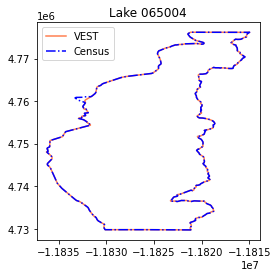

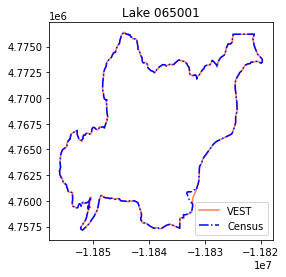

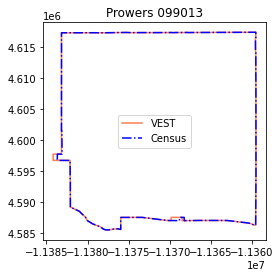

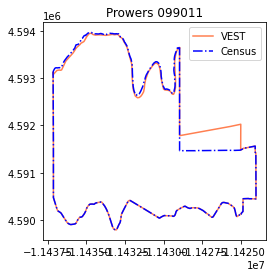

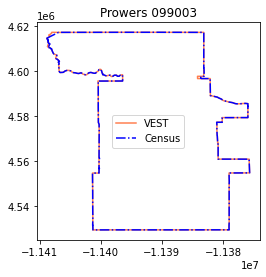

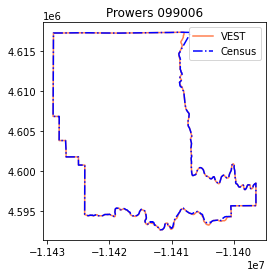

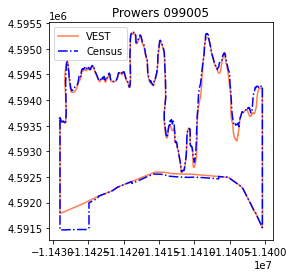

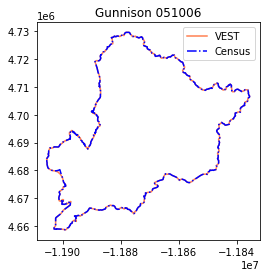

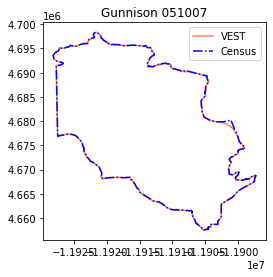

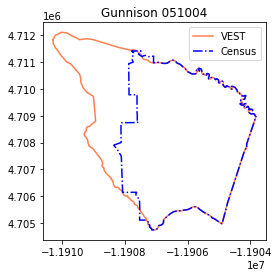

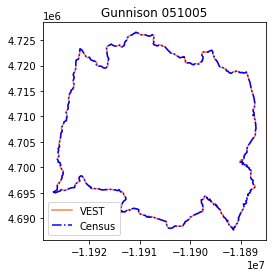

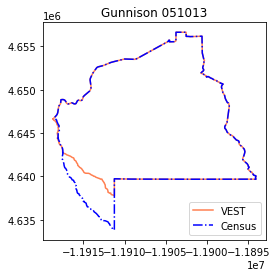

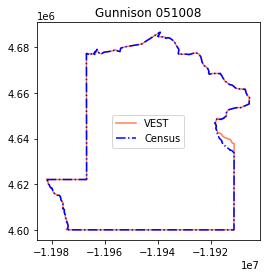

In [69]:
def safe_display(ax, geom, color=None, ls=None, lw=None, label=None):
    try:
        ax.plot(*geom.exterior.xy, c=color, ls=ls, lw=lw, label=label)
    except AttributeError:
        for g in geom.geoms:
            ax.plot(*g.exterior.xy, c=color, ls=ls, lw=lw, label=label)

more_than_one = diff_area[diff_area > 1]
diff_idxs = np.argsort(diff_area)[-len(more_than_one):]

GRAPH = True

county2idx = {recreated_vest_census["County_x"].iloc[i] : [j for j in diff_idxs \
                    if recreated_vest_census["County_x"].iloc[i] == recreated_vest_census["County_x"].iloc[j]] for i in diff_idxs}

for county, idxs in county2idx.items():
    print(county)
    print('-' * 20)
    for i in idxs:
        v = vest_shapes.iloc[i]
        c = census_shapes.iloc[i]
        
        name = recreated_vest_census["VTDST"].iloc[i]
        print(name)
        
        if GRAPH:

            fig, ax = plt.subplots(figsize=(4, 4))

            safe_display(ax, v, color="Coral", ls="-", label="VEST")
            safe_display(ax, c, color="Blue", ls="-.", label="Census")

            ax.set_title(county + " " + name)
            ax.legend()
    print()

In [70]:
# reset the cache
county2shape_cache = {}

### Part 2: Shapefiles sourced from individual counties:

#### Load counties for which county-level precinct shapefiles were used. 

In [71]:
relevant_paths = ["raw-from-source/county_download/" + \
                       f for f in os.listdir("raw-from-source/county_download/")]

county_shape_dfs = [(get_county_shapefile(relevant_paths, county), county) for county in counties]

county_shape_dfs = [df for df in county_shape_dfs if df[0] is not None]
county_shape_dfs = [(df[0].to_crs(CRS), df[1]) for df in county_shape_dfs]

add_county = []
for df, county in county_shape_dfs:
    df["County"] = county
    df.set_crs(CRS)
    add_county.append((df, county))
    
county_shape_dfs = add_county

In [95]:
def get_unique_id_col(df):
    """
    Used to extract a column containing unique IDs from a dataframe. 
    """
    cols = df.columns
    viable_cols = [col for col in cols if len(df[col]) == len(df[col].unique())]
    return viable_cols[0]
            

In [132]:
county2merge_df = {}
election_local_df = election_df[election_df["County"].isin([county for _, county in county_shape_dfs])].copy()

# shoot, it looks like Douglas county is being skipped each time, 
# will need to invetigate this more

for df, county in tqdm(county_shape_dfs):
# for df, county in [county_shape_dfs[12]]:
    
    geoms = []
    vest_ids = []
    raw_ids = []
    
    loc_vest = election_local_df[election_local_df["County"] == county].copy()
    
    unique_col = get_unique_id_col(df)

    for i in range(len(df)):
        raw_geom = df["geometry"].iloc[i]
        raw_id = str(df[unique_col].iloc[i])

        
        v_equal = loc_vest[loc_vest.geom_almost_equals(raw_geom)].copy()
        
        # we found an exact match
        if len(v_equal) == 1:
            v_name = v_equal["VTDST"]
            vest_ids.append(v_name)
            diff.append(0)
            continue
            
        # we will have to consider all vest precincts that intersect the raw precinct
        v_intersects = loc_vest[loc_vest.intersects(raw_geom)].copy()
        v_intersects.reset_index(inplace=True)
        area_diff = v_intersects.symmetric_difference(raw_geom).area.to_numpy() / 1e6
        
        # if there are no VEST precincts that interact, it could be a precinct
        # that did not contain any voters
        
        if len(area_diff) == 0:
            continue
        
        # select the vest precinct with the least amount of area that does not 
        # overlap with the raw precinct
        
        matching_vest = v_intersects.iloc[np.argmin(area_diff)]
        v_name = matching_vest["VTDST"]
        
        vest_ids.append(v_name)
        raw_ids.append(raw_id)
        geoms.append(raw_geom)
        
        
    county_df = gp.GeoDataFrame(data = {"VTDST" : vest_ids, "RAW_ID" : raw_ids}, geometry=geoms)
    try: 
        county_df = county_df.dissolve(by="VTDST", aggfunc="first", as_index=False)
        county2merge_df[county] = county_df
    except TypeError:
        print(f"{county} is a weird case, for some reason. ")
    

  0%|          | 0/18 [00:00<?, ?it/s]

#### Combine all locally sourced county shapefiles into one dataframe.

In [133]:
temp = pd.concat([val for val in county2merge_df.values()], axis=0)
local_df = gp.GeoDataFrame(temp, geometry=temp["geometry"], crs=CRS)

#### Check that VTDSTs match between two dataframes in preparation for the merge:

In [134]:
in_loc = local_df[~local_df["VTDST"].isin(election_local_df["VTDST"])]
in_v = election_local_df[~election_local_df["VTDST"].isin(local_df["VTDST"])]

print(len(in_loc))
print(len(in_v))

display(in_v["County"].value_counts())

0
158


Douglas     155
Arapahoe      2
Summit        1
Name: County, dtype: int64

In [156]:
# TODO for spencer, change this from a right merge once all the data comes in
recreated_vest_local = election_local_df.merge(local_county_shapes, on='VTDST', how="right")

vest_shapes = gp.GeoSeries(recreated_vest_local["geometry_x"], crs=CRS)
local_shapes = gp.GeoSeries(recreated_vest_local["geometry_y"], crs=CRS)

diff_area = vest_shapes.symmetric_difference(local_shapes).area.to_numpy() / 1e6
recreated_vest_local["DIFF AREA"] = diff_area

Text(0.5, 0, 'Difference in precinct area measured in km^2')

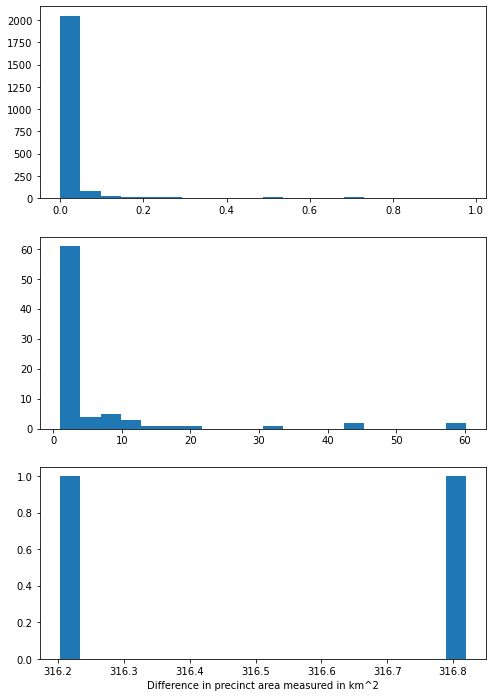

In [170]:
diff_area_low = diff_area[diff_area < 1]
diff_area_med = diff_area[(diff_area > 1) & (diff_area < 100)]
diff_area_high = diff_area[diff_area > 100]

fig, ax = plt.subplots(3, 1, figsize=(8,12))
ax = ax.flatten()

ax[0].hist(diff_area_low, bins=20)

ax[1].hist(diff_area_med, bins=20)

ax[2].hist(diff_area_high, bins=20)
ax[2].set_xlabel("Difference in precinct area measured in km^2")